In [186]:
# Importiamo tutte le librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from imblearn.over_sampling import SMOTE

from collections import Counter

In [187]:
# Caricamento del dataset
df_Neu_Net = pd.read_csv("data/df_EDA")


One-hot encoding delle variabili categoriche :
'person_home_ownership' e 'loan_intent' 

In [188]:
df_Neu_Net = pd.get_dummies(df_Neu_Net, columns=['person_home_ownership', 'loan_intent'], prefix=['home', 'intent'], drop_first=True)
for column in df_Neu_Net:
    if df_Neu_Net[column].dtype == bool:
        df_Neu_Net[column] = df_Neu_Net[column].astype(int)

df_Neu_Net

,person_age,person_education,person_income,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,home_OWN,home_RENT,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,22,3,71948.0,35000.0,16.02,0.49,3,561,0,1,0,1,0,0,0,1,0
1,21,0,12282.0,1000.0,11.14,0.08,2,504,1,0,1,0,1,0,0,0,0
2,25,0,12438.0,5500.0,12.87,0.44,3,635,0,1,0,0,0,0,1,0,0
3,23,2,79753.0,35000.0,15.23,0.44,2,675,0,1,0,1,0,0,1,0,0
4,24,3,66135.0,35000.0,14.27,0.53,4,586,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38539,27,1,47971.0,15000.0,15.66,0.31,3,645,0,1,0,1,0,0,1,0,0
38540,37,1,65800.0,9000.0,14.07,0.14,11,621,0,1,0,1,0,1,0,0,0
38541,33,1,56942.0,2771.0,10.02,0.05,10,668,0,1,0,1,0,0,0,0,0
38542,29,2,33164.0,12000.0,13.23,0.36,6,604,0,1,0,1,1,0,0,0,0


Separazione delle feature(X) e del target(y) : 

In [189]:
X = df_Neu_Net.drop(columns=['loan_status'])  # tutte le colonne tranne la target
y = df_Neu_Net['loan_status']                 # solo la target

Standardizzazione delle feature numeriche : 

In [190]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Divisione in train e test set :

In [191]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
) # stratify=y per mantenere bilanciata la distribuzione della variabile target

- Verifichiamo conteggio e percentuale di ambedue le classi(y):

In [192]:
print(df_Neu_Net['loan_status'].value_counts())
print(df_Neu_Net['loan_status'].value_counts(normalize=True) * 100)

loan_status
0    29143
1     9401
Name: count, dtype: int64
loan_status
0    75.609693
1    24.390307
Name: proportion, dtype: float64


### Calcolo di class weights(pesi di classe) :
        *solo se il dataset è sbilanciato

In [193]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.6612979325727031), 1: np.float64(2.049926871426672)}


Questo risultato --> Class Weights: {0: 0.66, 1: 2.05} <-- ci mostra l'avvenuto bilanciamento delle classi, quindi :

    - La rete neurale darà maggiore peso ai casi rari (1);
    - La rete neurale darà meno peso ai casi comuni (0).

Costruzione del modello : 

In [217]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'), # primo layer con 128 neuroni e attivazione ReLU
    Dropout(0.3), # dropout per prevenire l'overfitting
    Dense(64, activation='relu'), # primo layer con 64 neuroni e attivazione ReLU
    Dropout(0.3), # dropout per prevenire l'overfitting
    Dense(32, activation='relu'), # secondo layer con 32 neuroni e attivazione ReLU
    Dense(16, activation='relu'), # terzo layer con 16 neuroni e attivazione ReLU
    Dense(8, activation='relu'),  # quarto layer con 8 neuroni e attivazione ReLU
    Dense(1, activation='sigmoid')  # output layer con attivazione sigmoid per classificazione binaria
])


Compilazione del modello :

In [218]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

Early stopping per evitare overfitting :

In [219]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

Addestramento : 

In [220]:
history = model.fit(
    X_train, y_train,
    epochs=100, # Numero di epoche
    batch_size=32, # Dimensione del batch  
    validation_split=0.2,
    class_weight=class_weights,  # Qui usiamo i pesi
    callbacks=[early_stop]
)

Epoch 1/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7892 - loss: 0.3744 - val_accuracy: 0.8661 - val_loss: 0.2649
Epoch 2/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8670 - loss: 0.2485 - val_accuracy: 0.8756 - val_loss: 0.2426
Epoch 3/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8696 - loss: 0.2446 - val_accuracy: 0.8854 - val_loss: 0.2376
Epoch 4/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8840 - loss: 0.2316 - val_accuracy: 0.8784 - val_loss: 0.2325
Epoch 5/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8784 - loss: 0.2330 - val_accuracy: 0.8899 - val_loss: 0.2226
Epoch 6/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8863 - loss: 0.2265 - val_accuracy: 0.8808 - val_loss: 0.2297
Epoch 7/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8845 - loss: 0.2215 - val_accuracy: 0.8837 - val_loss: 0.2261
Epoch 8/100
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8870 - loss: 0.2172 - val_accu

-------------------------------------------------------------------------------

### Accuracy e Loss per epoche : 

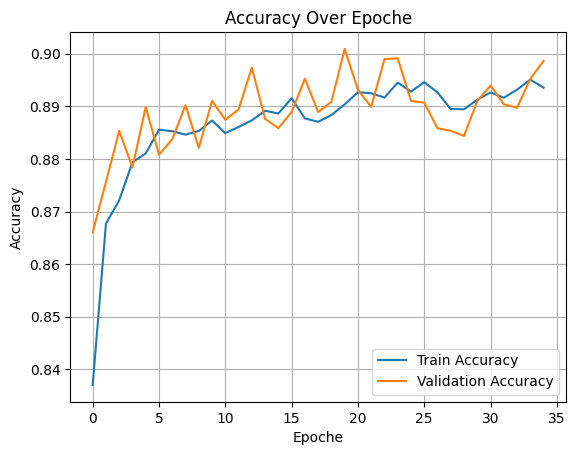

In [221]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epoche')
plt.grid(True)
plt.show()

### Accuracy Over Epoche
Il grafico ci mostra l'andamento della precisione (accuracy) su training set e validation set durante l’addestramento.

Osservazioni:

- La train accuracy cresce rapidamente all’inizio e poi si stabilizza.
- La validation accuracy segue un andamento simile, rimanendo sempre leggermente sopra o in linea con la train accuracy.

Interpretazione:

- Non ci sono grandi divergenze tra training e validation → non si evidenzia overfitting.
- L’accuratezza finale si aggira intorno a 0.89, un buon risultato, stabile nel tempo.



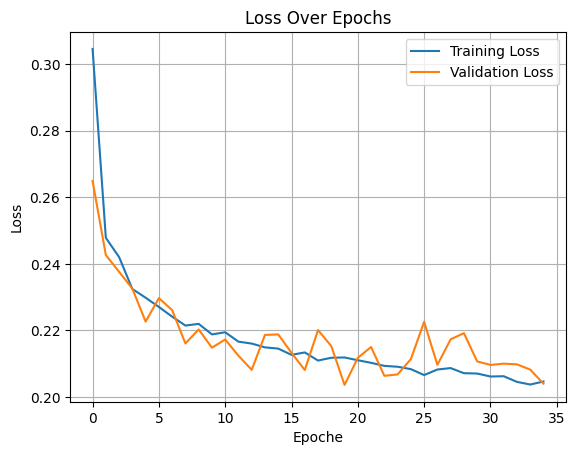

In [222]:
# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.grid(True)
plt.show()

### Loss Over Epochs
Il grafico ci mostra la funzione di costo (loss) durante le epoche per training e validation.

Osservazioni:

- Il training loss scende rapidamente e poi si stabilizza.
- Il validation loss segue un pattern simile e non mostra segni di peggioramento (che indicherebbe overfitting).

Interpretazione:

- Nessun segnale di overfitting o underfitting evidente.
- La rete apprende bene e generalizza in modo stabile sul validation set.

-------------------------------------------------------------------------------

Valutazione :

In [223]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8992 - loss: 0.2051
Test Accuracy: 0.9006
Test Loss: 0.2058


Predizione e Threshold per ottenere 0/1 :

In [224]:
y_pred_probs = model.predict(X_test).flatten() # Probabilità previste
y_pred = (y_pred_probs > 0.5).astype(int)  # treeshold di 0.5 per classificazione binaria


241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### Confusion Matrix :

[[5301  528]
 [ 238 1642]]


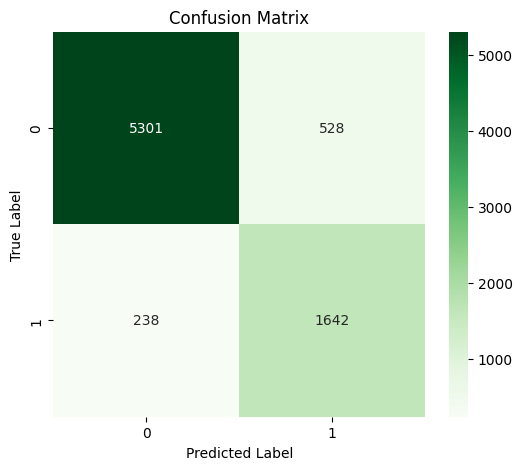

In [225]:
print(confusion_matrix(y_test, y_pred))

# Rappresentazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

plt.xlabel('Predicted Label') # valori predetti
plt.ylabel('True Label') # valori reali
plt.title('Confusion Matrix')
plt.show()



### Classification Report (Precision, Recall, F1) :

In [231]:
print(classification_report(y_test, y_pred, target_names=['Negato[0]', 'Approvato[1]']))

              precision    recall  f1-score   support

   Negato[0]       0.96      0.91      0.93      5829
Approvato[1]       0.76      0.87      0.81      1880

    accuracy                           0.90      7709
   macro avg       0.86      0.89      0.87      7709
weighted avg       0.91      0.90      0.90      7709



-------------------------------------------------------------------------------

### ROC Curve e AUC :

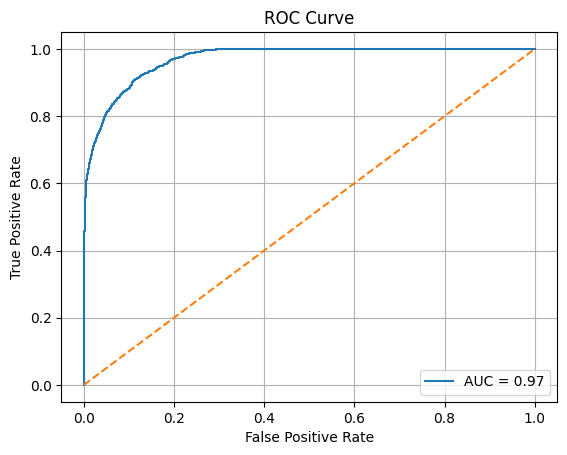

In [227]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


AUC = 0.97 indica che il modello ha una forte capacità discriminante: distingue molto bene le classi 0 e 1.

-------------------------------------------------------------------------------

Numero di feature (input) : 

In [228]:
X = df_Neu_Net.drop('loan_status', axis=1) # tutte le colonne tranne la target
n_features = X.shape[1]
print(f"Numero di feature: {n_features}")

Numero di feature: 16


Definizione dei layer per la visualizzazione :

In [229]:
layer_sizes = [n_features, 128, 64, 32, 16, 1]

Visualizzazione della rete neurale : 

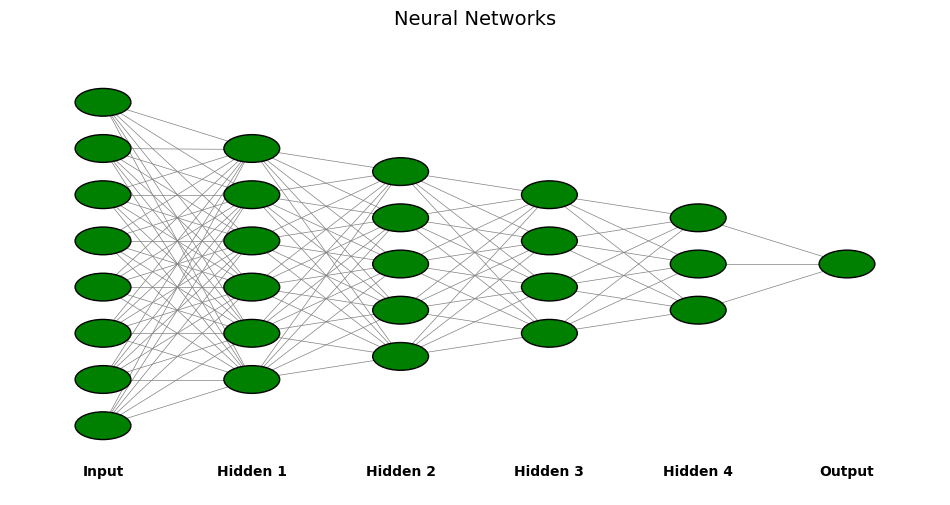

In [230]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, layer_labels=None, neuron_labels=None):
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(n_layers - 1)

    # Draw neurons
    for i, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        for j in range(layer_size):
            x = left + i * h_spacing
            y = layer_top - j * v_spacing
            circle = plt.Circle((x, y), 0.03, color='green', ec='k', zorder=4)
            ax.add_artist(circle)
            if neuron_labels and i < len(neuron_labels) and j < len(neuron_labels[i]):
                ax.text(x - 0.05, y, neuron_labels[i][j], fontsize=8, ha='right', va='center')

    # Draw connections
    for i, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for j in range(layer_size_a):
            for k in range(layer_size_b):
                line = plt.Line2D([left + i * h_spacing, left + (i + 1) * h_spacing],
                                  [layer_top_a - j * v_spacing, layer_top_b - k * v_spacing], c='gray', lw=0.5)
                ax.add_artist(line)

    # Draw layer labels at the bottom
    if layer_labels:
        for i, label in enumerate(layer_labels):
            x = left + i * h_spacing
            ax.text(x, bottom - 0.05, label, fontsize=10, ha='center', va='center', weight='bold')

# Parameters
layer_sizes = [8, 6, 5, 4, 3, 1]
layer_labels = ['Input', 'Hidden 1', 'Hidden 2', 'Hidden 3', 'Hidden 4', 'Output']

# Draw the figure
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, layer_sizes, layer_labels)
plt.title("Neural Networks", fontsize=14)
plt.show()
